[View in Colaboratory](https://colab.research.google.com/github/bhrgv-bolla/AI/blob/master/tensorflow-getting%20started/Iris.ipynb)

In [0]:
from __future__ import absolute_import, division, print_function

In [0]:
import os

In [0]:
import matplotlib.pyplot as plt

In [0]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe # to start tensorflow eager execution

tfe.enable_eager_execution()

In [5]:
print("TensorFlow version: {}".format(tf.VERSION))
print("Eager execution: {}".format(tfe.in_eager_mode()))

TensorFlow version: 1.6.0
Eager execution: True


In [6]:
train_dataset_url = "http://download.tensorflow.org/data/iris_training.csv"
train_dataset_fp = tf.keras.utils.get_file(fname=os.path.basename(train_dataset_url),
                                           origin=train_dataset_url)
print("Local copy of the dataset file: {}".format(train_dataset_fp))

Local copy of the dataset file: /content/.keras/datasets/iris_training.csv


In [7]:
!head -n5 {train_dataset_fp} # the first line is meta info. Total examples and 
# and num features, different labels (3 in this case)

120,4,setosa,versicolor,virginica
6.4,2.8,5.6,2.2,2
5.0,2.3,3.3,1.0,1
4.9,2.5,4.5,1.7,2
4.9,3.1,1.5,0.1,0


In [0]:
def parse_csv(line):
  example_defaults = [[0.], [0.], [0.], [0.], [0]] # sets field types.
  parsed_line = tf.decode_csv(line, example_defaults)
  #first 4 fields are features, combine into single tensor
  features = tf.reshape(parsed_line[:-1], shape=(4,))
  #Last field is label
  label = tf.reshape(parsed_line[-1], shape=())
  return features, label

In [9]:
train_dataset = tf.data.TextLineDataset(train_dataset_fp)
train_dataset = train_dataset.skip(1) #skip the first line # It is a header
train_dataset = train_dataset.map(parse_csv) # Use our parse function to parse
# each example row. 
train_dataset = train_dataset.shuffle(buffer_size=1000) #randomize
train_dataset = train_dataset.batch(32)

#view a single example entry from the batch
features, label = tfe.Iterator(train_dataset).next()
print("example features:", features[0])
print("example label:", label[0])

example features: tf.Tensor([5.7 3.  4.2 1.2], shape=(4,), dtype=float32)
example label: tf.Tensor(1, shape=(), dtype=int32)


In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation="relu", input_shape=(4,)), #Activatio
    # function think of it as a graph of how the output varies ( graph??)
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(3)
])
# ReLU is common for hidden layers. Rectified Linear Unit. 

In [0]:
# Defining the loss and the gradient function. 

# Logit is a function that maps probabilities (0,1) to R((-inf, 0inf))
def loss(model, x, y):
  y_ = model(x) # use model to predict the output.
  return tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_)

# Gradient move one gradient at a time. Descent?
def grad(model, inputs, targets):
  with tfe.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
  #print("###########################################")
  #print("model.varables: {}".format(model.variables))
  return tape.gradient(loss_value, model.variables)



In [0]:
#Creating an optimizer. 
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)

In [13]:
## Note: Rerunning this cell uses the same model variables .

#keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 201

for epoch in range(num_epochs):
  epoch_loss_avg = tfe.metrics.Mean()
  epoch_accuracy = tfe.metrics.Accuracy()
  
  #Training loop - using batches of 32
  for x, y in tfe.Iterator(train_dataset):
    #Optimize the model
    grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.variables),
                             global_step=tf.train.get_or_create_global_step())
    # print("model : ", model(x))
    #Track Progress
    epoch_loss_avg(loss(model, x, y)) # add current batch loss
    
    argmax = tf.argmax(model(x), axis=1, output_type=tf.int32)
    # compare predicted label to actual label
    epoch_accuracy(argmax, y) # tf.argmax returns the index of the largest value in the tensor. 
    
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())
  
  if epoch % 50 == 0:
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch, 
                                                               epoch_loss_avg.result()
                                                             , epoch_accuracy.result()))
  

Epoch 000: Loss: 1.441, Accuracy: 35.833%
Epoch 050: Loss: 0.522, Accuracy: 70.000%
Epoch 100: Loss: 0.376, Accuracy: 87.500%
Epoch 150: Loss: 0.289, Accuracy: 93.333%
Epoch 200: Loss: 0.201, Accuracy: 95.000%


In [14]:
# zip makes a tuple out of two or more arrays.
x = [1, 2, 3]
y = ['a', 'b', 'c']
z = zip(x, y)
print(z)
print(type(z), type(z[0]))

[(1, 'a'), (2, 'b'), (3, 'c')]
<type 'list'> <type 'tuple'>


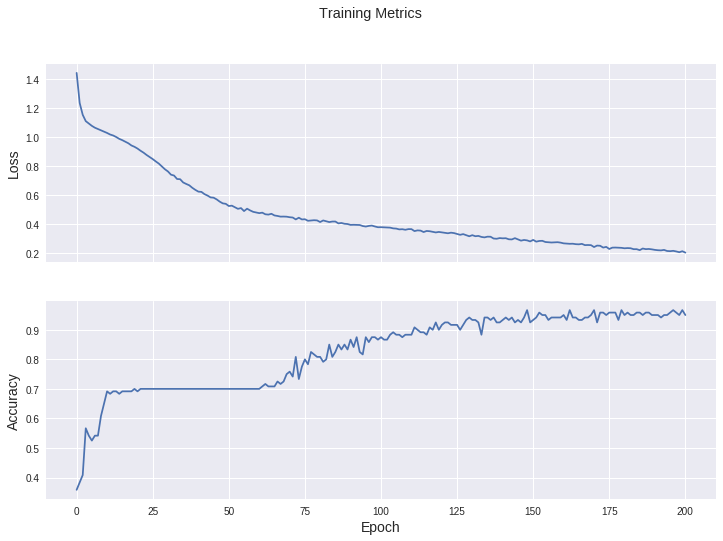

In [15]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle("Training Metrics")

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)

plt.show()

In [0]:
# test dataset

test_url = "http://download.tensorflow.org/data/iris_test.csv"

test_fp = tf.keras.utils.get_file(fname=os.path.basename(test_url), origin=test_url)

test_dataset = tf.data.TextLineDataset(test_fp)
test_dataset = test_dataset.skip(1)
test_dataset = test_dataset.map(parse_csv)
test_dataset = test_dataset.shuffle(1000) # randomize make the input size to 1000
test_dataset = test_dataset.batch(32)

In [21]:
test_accuracy = tfe.metrics.Accuracy()

for (x, y) in tfe.Iterator(test_dataset):
  prediction = tf.argmax(model(x), axis=1, output_type=tf.int32)
  test_accuracy(prediction, y)
  
print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

Test set accuracy: 93.333%


In [24]:
# using the trained model to make predictions. 


class_ids = ["Iris setosa", "Iris versicolor", "Iris virginica"]

predict_dataset = tf.convert_to_tensor([
    [5.1, 3.3, 1.7, 0.5,],
    [5.9, 3.0, 4.2, 1.5,],
    [6.9, 3.1, 5.4, 2.1]
])

predictions = model(predict_dataset)

for i, logits in enumerate(predictions):
  class_idx = tf.argmax(logits).numpy()
  name = class_ids[class_idx]
  print("Example {} prediction: {}".format(i, name))

Example 0 prediction: Iris setosa
Example 1 prediction: Iris versicolor
Example 2 prediction: Iris virginica
